Convolutional neural Network
============================

이번 실습에서는 지난 시간에 작성한 코드의 사용성을 더 개선하고 간단한 CNN모델을 구현해본다.
1. custom datasets 작성하기
2. W&B를 이용하여 학습및 평가 트래킹하기
3. CNN모델 구현하기

### Custom datasets 작성하기
``torch.utils.data.Dataset``는 dataset을 위한 추상클래스이다. custom dataset은 이 클래스를 상속하고 아래 두가지 메서드를 override하여야 한다:



* `__len__`을 구현하여 len(dataset)이 데이터셋 크기를 리턴한다

* `__getitem__` 을 구현하여 dataset[i] 와 같은 인덱싱에서 i번째 샘플을 리턴한다.

In [52]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
class CustomDatasetExample(Dataset):
    def __init__ (self , X, y):
        self.X = X
        self.y = y
        assert len(X) == len(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [54]:
data_x = torch.rand([10, 3], dtype=torch.float32) #example tensor dataset with 3 feature and 10 examples
data_y = torch.arange(10) # target y

example_dataset = CustomDatasetExample(data_x, data_y)
print(f"Dataset 크기: {len(example_dataset)}")
print(f"4-th example: {example_dataset[3]}\n")
for X, y in example_dataset:
    print(X, y)


Dataset 크기: 10
4-th example: (tensor([0.9845, 0.7677, 0.2093]), tensor(3))

tensor([0.3672, 0.3804, 0.6718]) tensor(0)
tensor([0.2177, 0.7828, 0.4940]) tensor(1)
tensor([0.7730, 0.4859, 0.0833]) tensor(2)
tensor([0.9845, 0.7677, 0.2093]) tensor(3)
tensor([0.9759, 0.1357, 0.4681]) tensor(4)
tensor([0.5023, 0.3217, 0.9399]) tensor(5)
tensor([0.3671, 0.6523, 0.1869]) tensor(6)
tensor([0.7567, 0.9222, 0.4860]) tensor(7)
tensor([0.8402, 0.8703, 0.1118]) tensor(8)
tensor([0.1001, 0.7966, 0.9285]) tensor(9)


이제 아래 csv파일로 부터 이미지 경로와 라벨 정보를 읽어오는 사용자정의 dataset을 구현해보자

In [55]:
pd.read_csv('resources/cat_dog_images/meta.csv')

,image_path,label
0,images_001/dog-01.jpg,dog
1,images_001/cat-01.jpg,cat
2,images_002/dog-02.jpg,dog
3,images_002/cat-02.jpg,cat
4,images_002/dog-03.jpg,dog
5,images_001/cat-03.jpg,cat


<mark>과제</mark>: root directory의 경로 "resources/cat_dog_images"와 이미지의 경로 및 label를 저장하고 있는 메타데이터 meta.csv파일을 입력으로 받는 custom datsets을 구현하라

* 이미지를 읽는데에는 [PIL.Image.open](https://pillow.readthedocs.io/en/stable/reference/Image.html) 함수를 사용할 것.

In [60]:
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, metadata_filename, transform=None, target_transform=None):
        self.metadata_df = pd.read_csv(os.path.join(root_dir, metadata_filename))
        self.root_dir = root_dir

        classes = self.metadata_df["label"].drop_duplicates().sort_values().tolist()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        ##### YOUR CODE START ##### 
        return len(self.metadata_df)

        ##### YOUR CODE END #####

    def __getitem__(self, idx):
        ##### YOUR CODE START #####  
        img_path = os.path.join(self.root_dir, self.metadata_df["image_path"].iloc[idx])
        image = Image.open(img_path)
        label_str = self.metadata_df['label'].iloc[idx]
    
        ##### YOUR CODE END #####

        label = self.class_to_idx[label_str] # encode label to integer

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [61]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

custom_dataset = CustomImageDataset(root_dir = 'resources/cat_dog_images', 
                                   metadata_filename = "meta.csv",
                                   transform = transform)

for i in range(len(custom_dataset)):
    image, target = custom_dataset[i]
    print(f"{i+1}-th example: X.shape = {image.shape}, label = {target}")

1-th example: X.shape = torch.Size([3, 800, 1200]), label = 1
2-th example: X.shape = torch.Size([3, 900, 1200]), label = 0
3-th example: X.shape = torch.Size([3, 800, 1200]), label = 1
4-th example: X.shape = torch.Size([3, 900, 1200]), label = 0
5-th example: X.shape = torch.Size([3, 900, 1200]), label = 1
6-th example: X.shape = torch.Size([3, 900, 742]), label = 0


In [62]:
def visualize_samples(dataset, cols=8, rows=5):
    figure = plt.figure(figsize=(12, 6))
    for i, example in enumerate(dataset):
        img, label = example
        figure.add_subplot(rows, cols, i+1)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.show()


Sum of pixel values: tensor(1156068.3750)


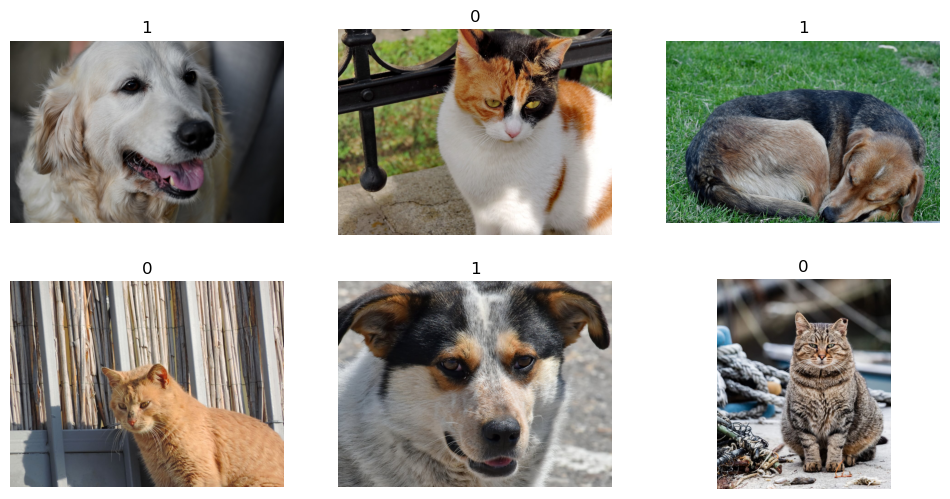

In [63]:
visualize_samples(custom_dataset, rows = 2 , cols = 3)

하지만 모든 샘플의 이미지 크기가 같지 않기 때문에 아래와 같이 dataloader를 이용해 mini-batch로 쌓으려고 하면 오류가 생긴다.

In [64]:
train_dataloader = DataLoader(dataset= custom_dataset, batch_size=6, shuffle=True)
for X, y in train_dataloader:
    print(X.shape, y)

RuntimeError: stack expects each tensor to be equal size, but got [3, 800, 1200] at entry 0 and [3, 900, 1200] at entry 2

따라서 transforms를 이용한 전처리가 필요하다.
``torchvision.transforms``에 다양한 이미지 전처리 함수가 이미 구현되어있다. 자세히는 [documentation](https://pytorch.org/vision/main/transforms.html)을 참고하기 바란다. 

여기서는 그 중 자주 사용되는 몇 가지를 소개한다.

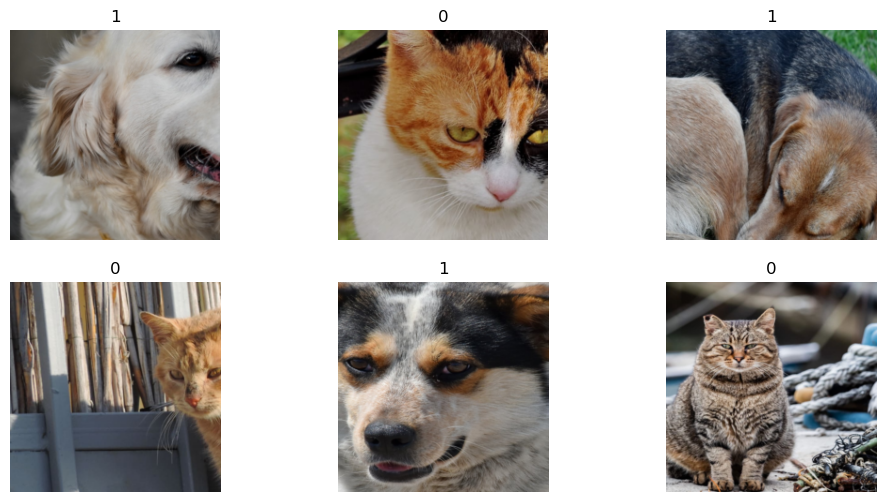

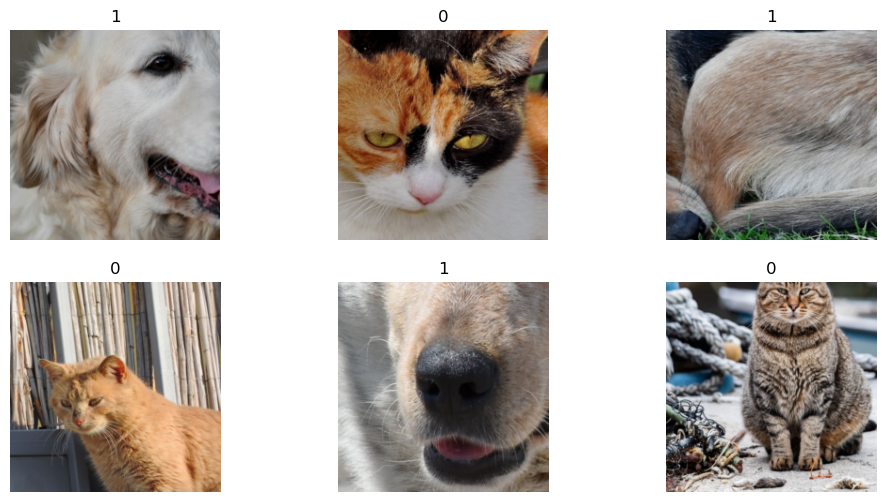

In [30]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

custom_datset_train = CustomImageDataset(root_dir = 'resources/cat_dog_images', 
                                   metadata_filename = "meta.csv",
                                   transform = train_transform)

visualize_samples(custom_datset_train, rows = 2 , cols = 3)
visualize_samples(custom_datset_train, rows = 2 , cols = 3)

데이터를 뽑을때 마다 랜덤하게 다른 augmented image가 출력되는것을 확인할 수 있다.
데이터로더에서도 (3, 224, 224) 크기의 이미지가 잘 출력됨을 확인할 수 있다

In [31]:
train_dataloader = DataLoader(dataset= custom_datset_train, batch_size=6, shuffle=True)
for X, y in train_dataloader:
    print(X.shape, y)

torch.Size([6, 3, 224, 224]) tensor([1, 1, 1, 0, 0, 0])


### custom Sampler로 weighted sampling하기

Sampler는 dataloader가 data를 추출하는 순서를 정해주는 객체로 datasets의 index를 순차적으로 리턴하는 iterator이다.

``__iter__``에서는 데이터셋의 순서를 정하는 로직을 통과한 뒤 그 인덱스들을 순회할수 있는 iterator를 반환한다.

아래 예시는 label imbalance를 해결하기 위해 각 class로 부터 같은 숫자의 샘플들을 추출하는 샘플러이다.

In [1]:
from torch.utils.data import Sampler
import random

class BalancedSampler(Sampler): 
    def __init__(self, dataset, class_column_name='label'):
        """
        Args:
            dataset: The dataset to sample from.
            class_column_name: The column name in the dataset that contains class labels.
        """
        self.dataset = dataset
        self.class_column_name = class_column_name
        
        # Group indices by class
        self.class_indices = {}
        for idx, label in enumerate(self.dataset.metadata_df[class_column_name]):
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(idx)
        
        self.min_class_length = min(len(indices) for indices in self.class_indices.values())
        
    def __iter__(self):
        selected_indices = []

        for class_name, indices in self.class_indices.items():
            sampled_indices = random.sample(indices, self.min_class_length)
            selected_indices.extend(sampled_indices)
        
        random.shuffle(selected_indices)
        return iter(selected_indices)
    
    def __len__(self):
        # The length of the sampler will be twice the minimum class length since we are balancing
        return self.min_class_length * len(self.class_indices)

In [33]:
custom_datset_imbalance = CustomImageDataset(root_dir = 'resources/cat_dog_images', 
                                   metadata_filename = "meta_imbalanced.csv",
                                   transform = train_transform)

print(f"this dataset has imbalanced label :{[target for image,target in custom_datset_imbalance]}\n")

balanced_sampler = BalancedSampler(custom_datset_imbalance)
print(f"class to dataset index dict: {balanced_sampler.class_indices}")
print(f"sampled index : {[idx for idx in balanced_sampler]}\n")

dataloader = DataLoader(custom_datset_imbalance, batch_size=32, sampler=balanced_sampler)
for X, y in dataloader:
    print(f"mini-batch X.shape = {X.shape}, target y = {y}")

this dataset has imbalanced label :[0, 1, 0, 1, 0]

class to dataset index dict: {'cat': [0, 2, 4], 'dog': [1, 3]}
sampled index : [0, 3, 2, 1]

mini-batch X.shape = torch.Size([4, 3, 224, 224]), target y = tensor([0, 0, 1, 1])


### 학습 코드 개선하기

아래는 지난 실습에서 작성한 학습코드를 다음의 측면에서 개선한 코드이다. 코드를 리뷰하며 다시 복습해보자.

- tqdm을 이용학 학습 시간 추적
- AverageMeter를 사용하여 학습 metric을 추적
- save_checkpoint와 load_checkpoint를 이용하여 모델을 저장하고 불러오는 기능 추가

In [34]:
import os, time, shutil

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import wandb

In [35]:
def load_MNIST_datasets(data_root_dir):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    train_dataset = datasets.MNIST(
        root=data_root_dir, train=True, download=True, 
        transform=transform
    )
    test_dataset = datasets.MNIST(
        root=data_root_dir, train=False, download=True, 
        transform=transform
    )

    return train_dataset, test_dataset

In [36]:
def create_dataloaders(train_dataset, test_dataset, device, batch_size, num_worker):
    kwargs = {}
    if device.startswith("cuda"):
        kwargs.update({
            'pin_memory': True,
        })

    train_dataloader = DataLoader(dataset = train_dataset, batch_size=batch_size, 
                                  shuffle=True, num_workers=num_worker, **kwargs)
    test_dataloader = DataLoader(dataset = test_dataset, batch_size=batch_size, 
                                 shuffle=False, num_workers=num_worker, **kwargs)
    
    return train_dataloader, test_dataloader

In [37]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name}: {avg' + self.fmt + '} (n={count}))'
        return fmtstr.format(**self.__dict__)

def calculate_accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res
    
def save_checkpoint(filepath, model, optimizer, epoch, best_acc1, is_best, best_model_path):
    save_dir = os.path.split(filepath)[0]
    os.makedirs(save_dir, exist_ok=True)

    state = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch + 1,
        'best_acc1': best_acc1,
    }
    
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, best_model_path)


def load_checkpoint(filepath, model, optimizer, device):
    if os.path.isfile(filepath):
        checkpoint = torch.load(filepath, map_location=device)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']
        best_acc1 = checkpoint['best_acc1']
        print(f"=> loaded checkpoint '{filepath}' (epoch {start_epoch})")
        return start_epoch, best_acc1
    else:
        print(f"=> no checkpoint found at '{filepath}'")
        return 0, 0

In [38]:
def train_loop(model, device, dataloader, criterion, optimizer, epoch):
    # train for one epoch
    losses = AverageMeter('Loss', ':.4e')
    acc_top1 = AverageMeter('Acc@1', ':6.2f')
    data_time = AverageMeter('Data_Time', ':6.3f') # Time for data loading
    batch_time = AverageMeter('Batch_Time', ':6.3f') # time for mini-batch train
    metrics_list = [losses, acc_top1, data_time, batch_time, ]
    
    model.train() # switch to train mode

    end = time.time()

    tqdm_epoch = tqdm(dataloader, desc=f'Training Epoch {epoch + 1}', total=len(dataloader))
    for images, target in tqdm_epoch:
        data_time.update(time.time() - end)

        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        output = model(images)
        loss = criterion(output, target)

        acc1, = calculate_accuracy(output, target, topk=(1,))
        losses.update(loss.item(), images.size(0))
        acc_top1.update(acc1[0], images.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)

        tqdm_epoch.set_postfix(avg_metrics = ", ".join([str(x) for x in metrics_list]))

        end = time.time()
    tqdm_epoch.close()

    ##### YOUR CODE START #####
    # wandb log following variables: losses.avg, acc_top1.avg
    wandb.log({"loss": losses.avg, 
               "acc_top1": acc_top1.avg})
    
    ##### YOUR CODE END #####

In [39]:
def evaluation_loop(model, device, dataloader, criterion, epoch = 0):
    losses = AverageMeter('Loss', ':.4e')
    acc_top1 = AverageMeter('Acc@1', ':6.2f')
    metrics_list = [losses, acc_top1]

    model.eval() # switch to evaluate mode

    with torch.no_grad():
        tqdm_val = tqdm(dataloader, desc='Validation/Test', total=len(dataloader))
        for images, target in tqdm_val:
            images = images.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)

            output = model(images)
            loss = criterion(output, target)

            acc1, = calculate_accuracy(output, target, topk=(1,))
            losses.update(loss.item(), images.size(0))
            acc_top1.update(acc1[0], images.size(0))

            tqdm_val.set_postfix(avg_metrics = ", ".join([str(x) for x in metrics_list]))

        tqdm_val.close()

    ##### YOUR CODE START #####
    wandb.log({"loss": losses.avg, 
               "acc_top1": acc_top1.avg})
    ##### YOUR CODE END #####

    return acc_top1.avg

In [40]:
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()

        self.flatten = nn.Flatten()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        x = self.flatten(x)

        logits = self.linear_relu_stack(x)
        return logits

In [41]:
def train_main_MLP():
    ## data and preprocessing settings
    data_root_dir = '/datasets' 
    num_worker = 4

    ## Hyper parameters
    batch_size = 128
    learning_rate = 1e-3
    start_epoch = 0
    num_epochs = 50

    ## checkpoint setting
    checkpoint_save_interval = 10
    checkpoint_path = "checkpoints/checkpoint.pth"
    best_model_path = "checkpoints/best_model.pth"
    load_from_checkpoint = None # Options: "latest", "best", or None

    ## variables
    best_acc1 = 0

    ## set learning deterministic
    # torch.manual_seed(1)

    ##### YOUR CODE START #####
    wandb.init(
        project="lab_03_cnn",
    
        config={
            "learning_rate": learning_rate,
            "architecture": "MLP",
            "dataset": "MNIST",
            "epochs": num_epochs,
    }
    )

    ##### YOUR CODE END #####


    device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    print(f"Using {device} device")

    train_dataset, test_dataset = load_MNIST_datasets(data_root_dir)
    num_classes = len(train_dataset.classes)
    
    train_dataloader, test_dataloader = create_dataloaders(train_dataset, test_dataset, device, 
                                                           batch_size = batch_size, num_worker = num_worker)


    model = MultiLayerPerceptron(in_dim = 28*28, hidden_dim = 512, out_dim = num_classes).to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

    if load_from_checkpoint:
        load_checkpoint_path = (best_model_path if load_from_checkpoint == "best" else checkpoint_path)
        start_epoch, best_acc1 = load_checkpoint(load_checkpoint_path, model, optimizer, device)

    for epoch in range(start_epoch, num_epochs):
        train_loop(model, device, train_dataloader, criterion, optimizer, epoch)
        acc1 = evaluation_loop(model, device, test_dataloader,criterion, epoch)


        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1)

        if (epoch + 1) % checkpoint_save_interval == 0 or is_best:
            save_checkpoint(checkpoint_path, model, optimizer, epoch, best_acc1, is_best, best_model_path)

    ##### YOUR CODE START #####
    wandb.log({"best_acc": best_acc1})
    if wandb.run:
        wandb.finish()

    ##### YOUR CODE END #####


<mark>과제</mark> [wandb](https://kr.wandb.ai/) 회원가입을 하고 메뉴얼에 따라 Train Loss, Train Accuracy, Validation Loss, Validation Accuracy를 추적하도록 위 함수들을 적절히 수정하고 학습해보라

In [42]:
train_main_MLP()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sangmin881717 (sangmin881717-university-of-suwon). Use `wandb login --relogin` to force relogin


Using cuda:0 device


Validation/Test: 100%|██████████| 79/79 [00:00<00:00, 577.76it/s, avg_metrics=Loss: 3.5008e-01 (n=10000)), Acc@1:  90.13 (n=10000))]


acc_top1,▁▂▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████████
best_acc,▁
loss,████▇▇▇▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc_top1,90.13
best_acc,90.13
loss,0.35008


<mark>과제</mark> wandb 로그 폴더와 checkpoint를 git에 올리지 않기 위에 `.gitignore`를 수정하라

(참고) shell 환경변수를 설정하여 wandb를 끌수있다.

In [43]:
os.environ['WANDB_DISABLED'] = 'true'
train_main_MLP()

Using cuda:0 device


Validation/Test: 100%|██████████| 79/79 [00:00<00:00, 800.47it/s, avg_metrics=Loss: 3.5261e-01 (n=10000)), Acc@1:  90.11 (n=10000))]


acc_top1,▁▂▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████████
best_acc,▁
loss,████▇▇▇▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc_top1,90.11
best_acc,90.11
loss,0.35261


### Training a small Convolutional Neural Network

CNN은 보통 아래 4개 레이어로 구성된다

- Convolutional layer
- Activation 
- Pooling layer
- FC layer

PyTorch에는 다양한 레이어가 있지만 우리는 그중 Conv2d, ReLU, Maxpool, Linear(FC) 레이어를 이용할 예정이다.

#### nn.Conv2d

parameter

- in_channels(int) : Number of input images channel
- out_channels(int) : Number of filters
- kernel_size(int or tuple) : 필터의 크기는 kernel_size * kernel_size이다
- stride(int or tuple) : Default = 1
- padding(int or tuple) : zero padding. Default = 0

In [44]:
input_image = torch.rand(16, 1, 28, 28) # dummy data with batch_size 16
conv_layer1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5)
x = conv_layer1(input_image)
print(x.shape)

torch.Size([16, 8, 24, 24])


#### nn.MaxPool2d

parameter
- kernel_size – the size of the window to take a max over
- stride – the stride of the window. (Default = kernel_size)
- padding – implicit zero padding to be added on both sides (default = 0)

In [45]:
pool_layer = nn.MaxPool2d(kernel_size = 2, stride = 2)
x = pool_layer(x)
print(x.shape)

torch.Size([16, 8, 12, 12])


이제 CNN 모델을 구현할 준비가 완료되었다.

<mark>과제</mark> 아래 구조의 CNN모델을 완성하라

* 5x5 Convolutional layer with 8 filters, strides of 1, no zero padding, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* 5x5 Convolutional layer with 16 filters, strides of 1, no zero padding, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* Fully connected layer with 128 output units and ReLU activation
* Fully connected layer with 64 output units and ReLU activation
* Fully connected layer with 10 output units 

In [46]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        ##### YOUR CODE START #####
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.Linear(in_features=16*4*4, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10)
        )
        ##### YOUR CODE END #####

    def forward(self, x):
        ##### YOUR CODE START #####
        x = self.model(x)

        ##### YOUR CODE END #####

        return x

파라미터 수를 스스로 계산해보고 맞게 구현됐는지 검증하라

- Conv layer = filter number x filter size x filter size + bias(filter number)
- FC layer = input size x output size + bias(output size)

In [47]:
cnn_model = SimpleCNN()
for name, param in cnn_model.named_parameters():
    print(f"Layer {name} # of params : {param.numel()}")
total_params = sum(p.numel() for p in cnn_model.parameters())

print(f"Total number of params : {total_params}")

Layer model.0.weight # of params : 200
Layer model.0.bias # of params : 8
Layer model.3.weight # of params : 3200
Layer model.3.bias # of params : 16
Layer model.7.weight # of params : 32768
Layer model.7.bias # of params : 128
Layer model.9.weight # of params : 8192
Layer model.9.bias # of params : 64
Layer model.11.weight # of params : 640
Layer model.11.bias # of params : 10
Total number of params : 45226


<mark>과제</mark> 학습을 수행하여 MLP 모델과의 결과를 비교하라.

In [48]:
def train_main_CNN():
    ##### YOUR CODE START #####
    ## data and preprocessing settings
    data_root_dir = '/datasets' 
    num_worker = 4

    ## Hyper parameters
    batch_size = 128
    learning_rate = 1e-3
    start_epoch = 0
    num_epochs = 50

    ## checkpoint setting
    checkpoint_save_interval = 10
    checkpoint_path = "checkpoints/checkpoint.pth"
    best_model_path = "checkpoints/best_model.pth"
    load_from_checkpoint = None # Options: "latest", "best", or None

    ## variables
    best_acc1 = 0

    ## set learning deterministic
    # torch.manual_seed(1)

    ##### YOUR CODE START #####
    wandb.init(
        project="lab_03_cnn",
    
        config={
            "learning_rate": learning_rate,
            "architecture": "CNN",
            "dataset": "MNIST",
            "epochs": num_epochs,
    }
    )

    ##### YOUR CODE END #####


    device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    print(f"Using {device} device")

    train_dataset, test_dataset = load_MNIST_datasets(data_root_dir)
    num_classes = len(train_dataset.classes)
    
    train_dataloader, test_dataloader = create_dataloaders(train_dataset, test_dataset, device, 
                                                           batch_size = batch_size, num_worker = num_worker)


    model = SimpleCNN().to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

    if load_from_checkpoint:
        load_checkpoint_path = (best_model_path if load_from_checkpoint == "best" else checkpoint_path)
        start_epoch, best_acc1 = load_checkpoint(load_checkpoint_path, model, optimizer, device)

    for epoch in range(start_epoch, num_epochs):
        train_loop(model, device, train_dataloader, criterion, optimizer, epoch)
        acc1 = evaluation_loop(model, device, test_dataloader,criterion, epoch)


        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1)

        if (epoch + 1) % checkpoint_save_interval == 0 or is_best:
            save_checkpoint(checkpoint_path, model, optimizer, epoch, best_acc1, is_best, best_model_path)

    wandb.log({"best_acc": best_acc1})
    if wandb.run:
        wandb.finish()

    ##### YOUR CODE END #####


In [49]:
train_main_MLP()

Using cuda:0 device


Validation/Test: 100%|██████████| 79/79 [00:00<00:00, 714.62it/s, avg_metrics=Loss: 3.5235e-01 (n=10000)), Acc@1:  90.14 (n=10000))]


acc_top1,▁▂▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████████████
best_acc,▁
loss,████▇▇▇▆▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc_top1,90.14
best_acc,90.14
loss,0.35235
